# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib import colors
import sdf
import re
import imageio as imageio
import glob

plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (10, 8)


# Parameters

## Physical Constants

In [2]:
m = 9.10938356e-31
e = 1.60217662e-19
c = 299792458
PI = np.pi
epsilon = 8.85e-12

## Constants From Simulation

In [3]:
DATA_DIR = "before"
with open (os.path.join(DATA_DIR, "input.deck"), "r") as myfile:
    data=myfile.read()

The parameters which we want to extract are:
* Wavelength: `lambda`
* Laser Time: `las_time`
* Vector Potential: `a0`
* The density factor: `factor`
* Number of Cells: `nx`
* Simulation End Time: `t_end`
* Size of Box: `x_min`
* dt: `dt_snapshot`

In [4]:
def find_value(info):
    regex = re.compile(rf"\s{info}\s*=\s*-?(\d+\.?\d*)")
    match = regex.search(data)
    if match:
        return float(match.group(1))
    else:
        return None

In [5]:
LAMBD= find_value("lambda0")*1e-6
LAS_TIME = int(find_value("las_time"))
T_MAX = int(find_value("t_end"))
DT = find_value("dt_snapshot")*1e-15
A0 = find_value("a0")
FACTOR = int(find_value("factor"))
NX = int(find_value("nx"))
X_MIN = -int(find_value("x_min"))

print("Values from input.deck:")
print("lambda0 = ", LAMBD)
print("laser_time = ", LAS_TIME)
print("t_end = ", T_MAX)
print("dt_snapshot = ", DT)
print("a0 = ", A0)
print("factor = ", FACTOR)
print("nx = ", NX)
print("x_min = ", X_MIN)

Values from input.deck:
lambda0 =  1e-06
laser_time =  20
t_end =  40
dt_snapshot =  8e-17
a0 =  0.5
factor =  7
nx =  16000
x_min =  -25


## Calculated Constants

In [6]:
omega0 = 2*PI*c/LAMBD
tau = 2*PI/omega0
nc = epsilon*m*omega0**2/e**2
Er = m * omega0 * c / e
n0 = FACTOR*nc
LAS_TIME = LAS_TIME*tau
print("Calculated Values for the simulation are:")
print("omega0 = ", omega0)
print("tau = ", tau)
print("nc = ", nc)
print("Er = ", Er)
print("n0 = ", n0)

Calculated Values for the simulation are:
omega0 =  1883651567308853.2
tau =  3.3356409519815205e-15
nc =  1.1143269197457677e+27
Er =  3210701072782.3525
n0 =  7.800288438220374e+27


## Values for FT

In [7]:
omega_to_resolve = 20*omega0
f_max_to_resolve = omega_to_resolve/(2*PI)
dt_max_to_resolve = 1/(2*f_max_to_resolve)
print(f"The maximum time step for resolution is {dt_max_to_resolve*1e15} femto seconds")

The maximum time step for resolution is 0.08339102379953801 femto seconds


In [8]:
f_max = 1/(DT)
omega_max = 2*np.pi*f_max
omega_max/omega0

41.69551189976901

## Other Variables

In [9]:
ALL_FILES = glob.glob(f"{DATA_DIR}/*sdf")
ALL_FILES.sort()
len(ALL_FILES)

1669

In [10]:
X = np.linspace(X_MIN, -X_MIN, NX)
T = np.linspace(0, T_MAX, len(ALL_FILES))

# Original Pulse

In [11]:
def get_pulse(t):
    if t<LAS_TIME:
        return np.sin(omega0*t)*(np.sin(np.pi*t/LAS_TIME))**2
    else:
        return 0

get_pulse = np.vectorize(get_pulse)

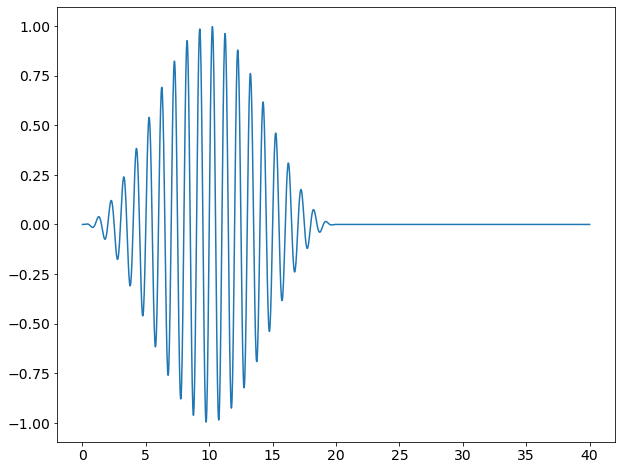

In [14]:
T_O = np.arange(0,len(ALL_FILES))*DT
pulse = get_pulse(T_O)

plt.plot(T_O/tau, pulse)

# Plots

In [15]:
data = sdf.read(ALL_FILES[100])

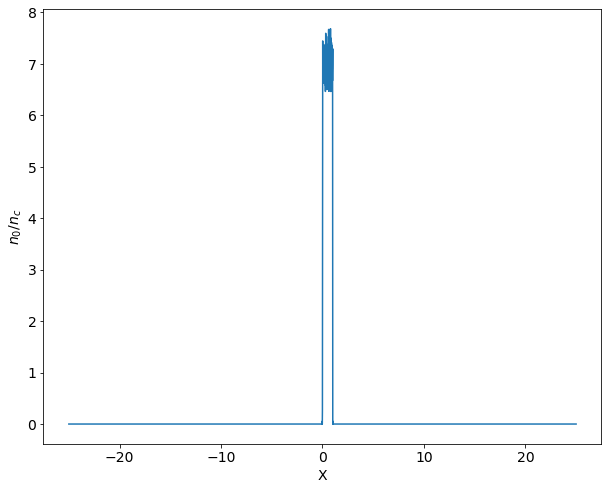

In [16]:
plt.plot(X, data.Derived_Number_Density_Electron.data/nc)
plt.xlabel("X")
plt.ylabel("$n_0/n_c$");

In [17]:
def get_field(id, component="y"):
    raw_data = sdf.read(ALL_FILES[id])
    comp = {
        "x": raw_data.Electric_Field_Ex,
        "y": raw_data.Electric_Field_Ey,
        "z": raw_data.Electric_Field_Ez,
    }
    field = comp[component].data
    return field


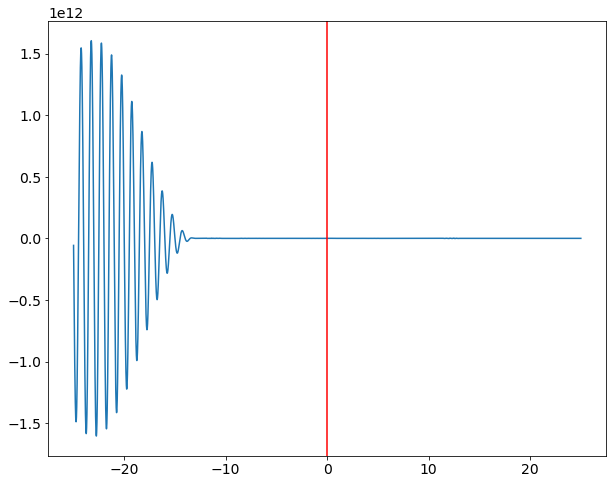

In [18]:
Ey = get_field(500)
plt.plot(X, Ey)
plt.axvline(0, color="red")
plt.show()


In [89]:
Et0 = np.zeros(len(ALL_FILES))
Et1 = np.zeros(len(ALL_FILES))
Et2 = np.zeros(len(ALL_FILES))
d = np.zeros((len(ALL_FILES), NX))
for i in range(len(ALL_FILES)):
    data = sdf.read(ALL_FILES[i])
    ey = data.Electric_Field_Ey.data
    Et0[i] = ey[0]
    Et1[i] = ey[7000]
    Et2[i] = ey[8000]
    d[i] = data.Derived_Number_Density_Electron.data


In [90]:
d.shape, Et0.shape

((1669, 16000), (1669,))

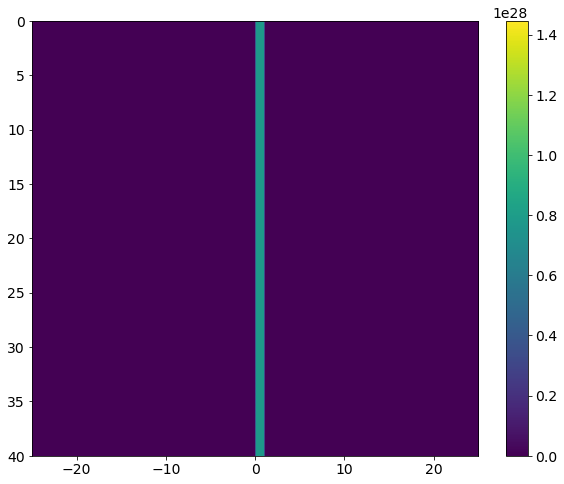

In [91]:
EXTENT = [X_MIN,-X_MIN,T_MAX,0]
plt.imshow(d, aspect="auto", extent=EXTENT)
cmap = colors.ListedColormap(["white", "black"])
plt.colorbar(cmap=cmap)

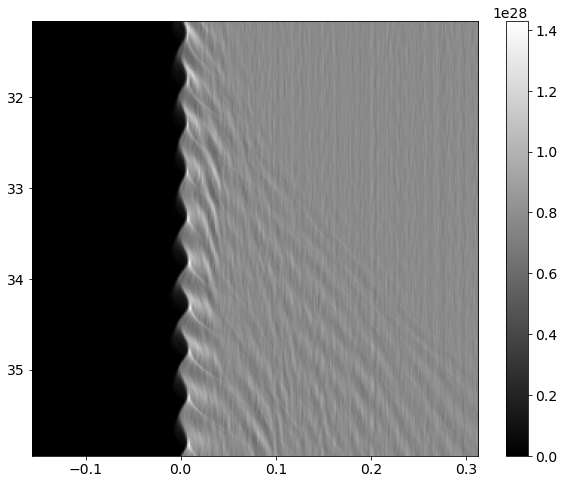

In [92]:
t_start = 1300
t_end = 1500
t_max = d.shape[0]
x_max = d.shape[1]
x_start = 2*3950
x_end = 2*4100
EXTENT = [-X_MIN*(x_start-NX//2)/x_max,-X_MIN*(x_end-NX//2)/x_max,T_MAX*t_end/t_max,T_MAX*t_start/t_max]
plt.imshow(d[t_start:t_end, x_start:x_end], aspect="auto", extent=EXTENT, cmap="gray")
cmap = colors.ListedColormap(["white", "black"])
plt.colorbar(cmap=cmap)

# Before

In [93]:
node = 8000/NX*40
node_t = node*tau
node_t

6.671281903963041e-14

In [94]:
node

20.0

In [95]:
pulse = np.zeros(len(ALL_FILES))
for i, time in enumerate(T_O):
    if time<=node_t:
        pass
    elif time >= (LAS_TIME+node_t):
        pass
    else:
        pulse[i] = np.sin(omega0*(time-node_t))*(np.sin(np.pi*(time-node_t)/(LAS_TIME)))**2


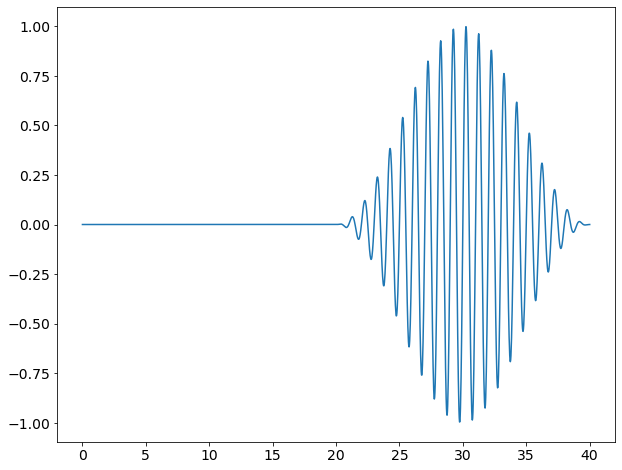

In [96]:
plt.plot(T_O/tau, pulse)

In [85]:
T_node = np.arange(0,len(ALL_FILES))*DT

In [97]:
pulse = pulse/np.max(pulse)
Et0 = Et0/np.max(Et0)
Et1 = Et1/np.max(Et1)
Et2 = Et2/np.max(Et2)

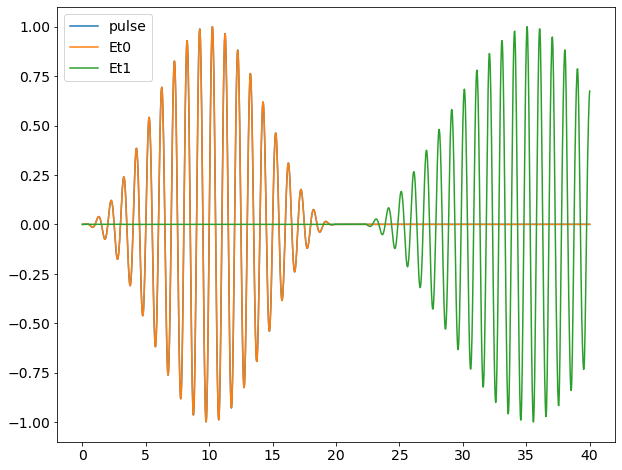

In [87]:
plt.plot(T, pulse, label="pulse")
plt.plot(T, Et0, label="Et0")
plt.plot(T, Et1, label="Et1")
plt.legend();


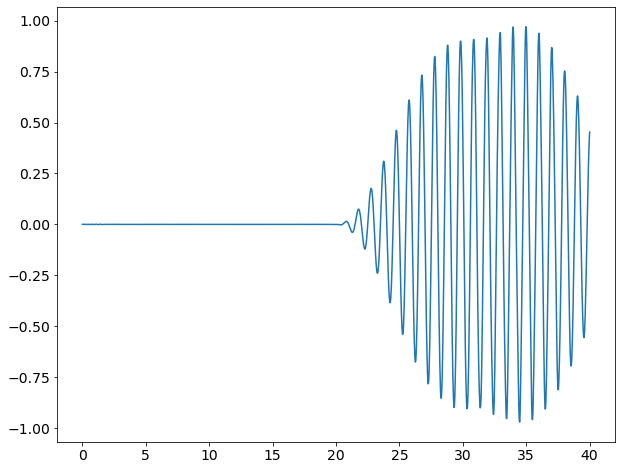

In [98]:
plt.plot(T, Et2-pulse, label="Et1-pulse")

In [188]:
half = int(len(ALL_FILES)/3)
shift = 0
Et0_half = Et0[shift:half+shift]
Et1_half = Et1[shift:half+shift]
Et2_half = Et2[shift:half+shift]
T_half = T[:half]
pulse_half = pulse[:half]

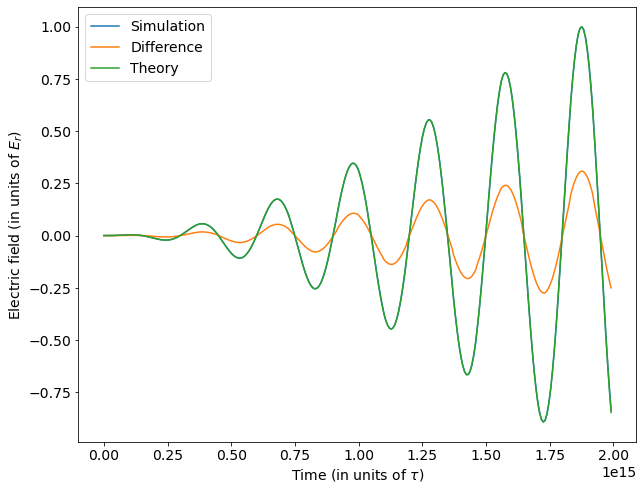

In [192]:
plt.plot(T_half/tau, Et0_half/Et0_half.max(), label="Simulation")
plt.plot(T_half/tau,( Et0_half/Et0_half.max()-pulse_half), label="Difference")
plt.plot(T_half/tau, pulse_half/pulse_half.max(), label="Theory")
plt.xlabel("Time (in units of $\\tau$)")
plt.ylabel("Electric field (in units of $E_r$)")
plt.legend()
plt.show()

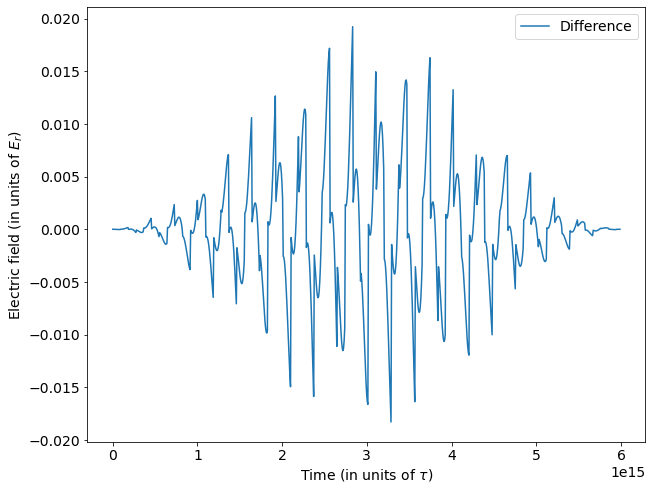

In [ ]:
plt.plot(T_half/tau,( Et0_half/Et0_half.max()-pulse_half), label="Difference")
# plt.plot(T_half/tau, pulse_half, label="Theory")
plt.xlabel("Time (in units of $\\tau$)")
plt.ylabel("Electric field (in units of $E_r$)")
plt.legend()
plt.show()

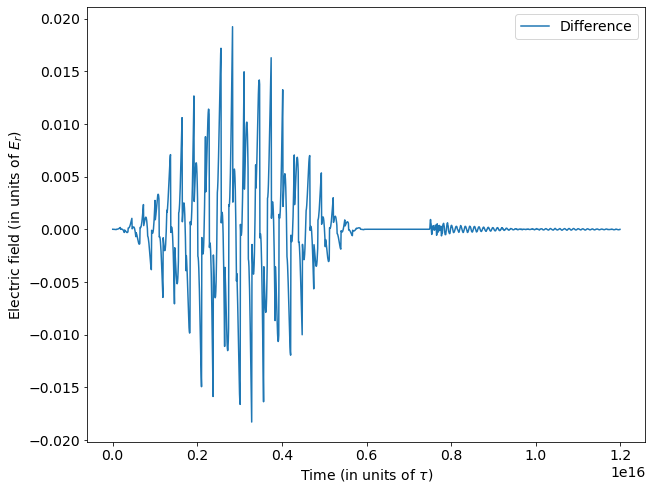

In [ ]:
plt.plot(T/tau, ((Et0/Et0.max())-pulse), label="Difference")
# plt.plot(T/tau, pulse, label="Theory")
plt.xlabel("Time (in units of $\\tau$)")
plt.ylabel("Electric field (in units of $E_r$)")
plt.legend()
plt.show()

## FT

In [100]:
y0 = np.fft.fft(Et0)
y4 = np.fft.fft(Et2-pulse)
# y1 = np.fft.fft(Et1)
# y2 = np.fft.fft(Et2)

In [101]:
# y1_shift = np.fft.fftshift(y1)
# y2_shift = np.fft.fftshift(y2)
y0_shift = np.fft.fftshift(y0)
y4_shift = np.fft.fftshift(y4)
# y1_f = np.abs(y1_shift)/Er
# y2_f = np.abs(y2_shift)/Er
y0_f = np.abs(y0_shift)/Er

In [102]:
omega = np.linspace(-omega_max/2, omega_max/2, len(ALL_FILES))

In [103]:
omega_max/omega0

41.69551189976901

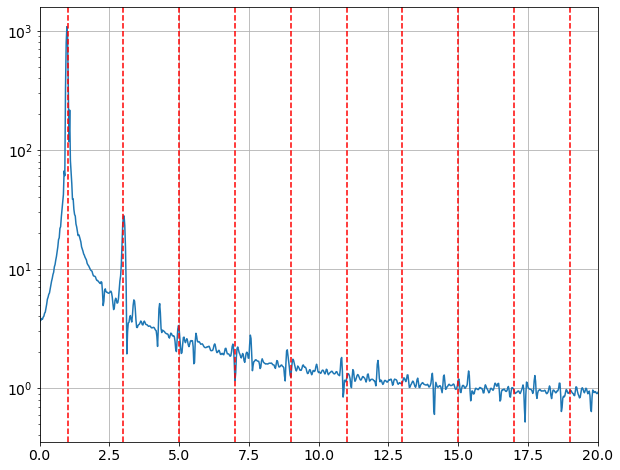

In [106]:
plt.plot(omega/omega0, 2*np.abs(y4_shift)*2)
plt.yscale("log")
points = np.arange(1,21,2)
for p in points:
    plt.axvline(p, color="red", linestyle="--")
    plt.annotate(f"{p}", (p, 1e-2))
plt.xlim(0,20)
plt.grid()

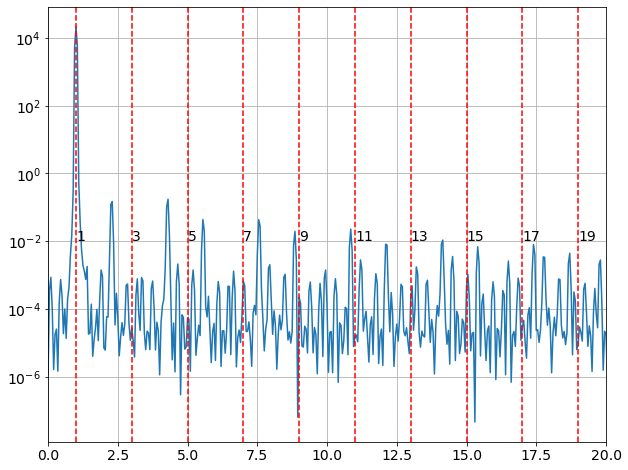

In [197]:
plt.plot(omega/omega0, 2*y0_f**2)
plt.yscale("log")
points = np.arange(1,21,2)
for p in points:
    plt.axvline(p, color="red", linestyle="--")
    plt.annotate(f"{p}", (p, 1e-2))
plt.xlim(0,20)
plt.grid()

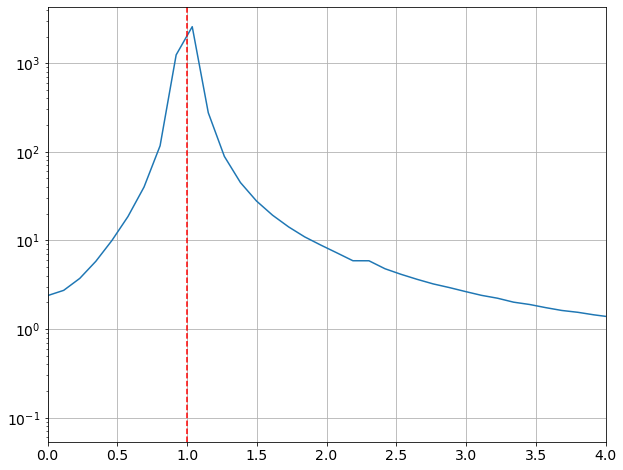

In [198]:
half = int(len(ALL_FILES)/2.3)
y0half = np.fft.fft(Et0[:half])
y0half_f = np.abs(np.fft.fftshift(y0half))/Er
omega = np.linspace(-omega_max/2, omega_max/2, half)
plt.plot(omega/omega0, 2*np.square(y0half_f))
plt.yscale("log")
# points = np.arange(1,21,2)
# for p in points:
    # plt.axvline(p, color="red", linestyle="--")
    # plt.annotate(f"{p}", (p, 1e-2))
plt.axvline(1, color="red", linestyle="--")
plt.xlim(0,4)
plt.grid()